## RNN Train Script

Este es el archivo donde se hará una prueba de clasificador automático mediante CNN (Convolutional Neural Network).

De manera independiente se van a cargar las librerías necesarias para el script.
A la hora de realizar este script, Tensorflow/Keras no es aún compatible con Python 3.12, así que se usará la versión de Python 3.11.6

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Para puntualizar ahora mismo, se añadirán mas tipos en un futuro.
1. original_signals → Etiqueta 0.
2. flicker_signals → Etiqueta 1.
3. harmonic_signals → Etiqueta 2.
4. Interruption_signals → Etiqueta 3.
5. original_signals → Etiqueta 4.
6. Swell_signals → Etiqueta 5.
7. transient_signals → Etiqueta 6.

In [6]:
# Función para procesar señales
def preprocess_signal(signal):
    
    # Seleccionamos un objetivo de Ruido.
    Obj_snr_db = 10
    # Calculamos el poder de la señal y la pasamos a dB
    # Necesitamos calcular la potencia, en este caso sería:
    x_watts = signal ** 2
    
    #Antes de sacar las características, se le añade ruido en el siguiente fragmento de código.
    # --------------        
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - Obj_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generamos una muestra de ruido blanco.
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    # Sumamos el ruido a la señal
    signal_20dB = signal + noise_volts
    # -------------- 
    
    # Parámetros teóricos
    max_theoretical_value = 230 * np.sqrt(2)

    # Media de la señal
    mean_value = np.mean(signal_20dB)

    # Datos sin sesgo
    unbias_data = signal_20dB - mean_value
    unbias_data_2 = unbias_data ** 2
    unbias_data_3 = unbias_data_2 * unbias_data
    unbias_data_4 = unbias_data_3 * unbias_data

    # Cálculo de características
    variance = np.var(unbias_data)  # Varianza
    skewness = np.mean(unbias_data_3) / (variance ** 1.5)  # Asimetría
    kurtosis = np.mean(unbias_data_4) / (variance ** 2) - 3  # Curtosis
    thd = np.sqrt(np.sum(np.abs(np.fft.fft(signal_20dB)[2:4])) / np.abs(np.fft.fft(signal_20dB)[1]))  # Distorsión armónica total
    rms = np.sqrt(np.mean(signal_20dB ** 2))  # Valor RMS
    crest_factor = np.max(signal_20dB) / rms  # Factor de cresta

    # Devuelve todas las características en un vector
    return np.array([variance, skewness, kurtosis, thd, crest_factor])

# Función para cargar señales y extraer características
def load_signal(data_path):
    label_mapping = {
        "flicker_signals": 0,
        "harmonic_signals": 1,
        "interruption_signals": 2,
        "original_signals": 3,
        "sag_signals": 4,
        "swell_signals": 5,
        "transient_signals": 6,
        "harmonic_sag_signals": 7,
        "harmonic_swell_signals": 8,
        "Harmonic_interruption_signals": 9,
    }

    features = []
    labels = []

    for signal_type, label in label_mapping.items():
        signal_type_path = os.path.join(data_path, signal_type)
        if os.path.isdir(signal_type_path):
            for subset in ["train", "test", "val"]:
                subset_path = os.path.join(signal_type_path, subset)
                if os.path.exists(subset_path):
                    for filename in os.listdir(subset_path):
                        if filename.endswith(".npy"):
                            file_path = os.path.join(subset_path, filename)
                            signal = np.load(file_path)
                            feature_vector = preprocess_signal(signal)
                            features.append(feature_vector)
                            labels.append(label)

    return np.array(features), np.array(labels)

# Cargar datos
data_path = "data"  # Cambiar por la ruta adecuada
features, labels = load_signal(data_path)

In [7]:
# Dividir los datos
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Ajustar las dimensiones de los datos para el modelo LSTM
X_train = X_train[..., np.newaxis]  # Agregar una dimensión adicional
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Confirmar las formas esperadas para LSTM: (batch_size, sequence_length, features)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])  # (batch_size, sequence_length=1, features)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print("Formas ajustadas para LSTM:")
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

# Convertir etiquetas a one-hot encoding si no están ya en ese formato
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_val_one_hot = to_categorical(y_val, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

# Modelo LSTM
model = Sequential([
    LSTM(128, activation='tanh', kernel_regularizer=l2(0.001), input_shape=(1, X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh',return_sequences=True),
    Dropout(0.3),
    LSTM(64, activation='tanh',return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dense(10, activation='sigmoid')  # Capa de salida para 10 clases
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train_one_hot,
                    validation_data=(X_val, y_val_one_hot),
                    epochs=50,
                    batch_size=32)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {accuracy:.2f}")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_one_hot, axis=1)

class_report = classification_report(y_test_classes, y_pred_classes)
print("Informe de Clasificación:\n", class_report)

Formas ajustadas para LSTM:
X_train: (75600, 1, 5), X_val: (16200, 1, 5), X_test: (16200, 1, 5)
Epoch 1/50


/Users/saguadog/Documents/TesisSergioAguado/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2363/2363 ━━━━━━━━━━━━━━━━━━━━ 58s 24ms/step - accuracy: 0.1661 - loss: 2.1449 - val_accuracy: 0.4077 - val_loss: 1.4792
Epoch 2/50
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.3940 - loss: 1.4832 - val_accuracy: 0.4584 - val_loss: 1.2970
Epoch 3/50
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.4376 - loss: 1.3186 - val_accuracy: 0.5192 - val_loss: 1.1608
Epoch 4/50
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.4819 - loss: 1.1951 - val_accuracy: 0.5704 - val_loss: 1.0831
Epoch 5/50
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.5166 - loss: 1.1135 - val_accuracy: 0.6120 - val_loss: 1.0234
Epoch 6/50
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.5464 - loss: 1.0531 - val_accuracy: 0.6273 - val_loss: 0.9666
Epoch 7/50
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.5729 - loss: 1.0061 - val_accuracy: 0.6467 - val_loss: 0.9100
Epoch 8/50
2363/2363 ━━━━━━━━━━━━━━━━━━━━ 55s 23ms/step - accuracy: 0.6036 - loss: 0.95

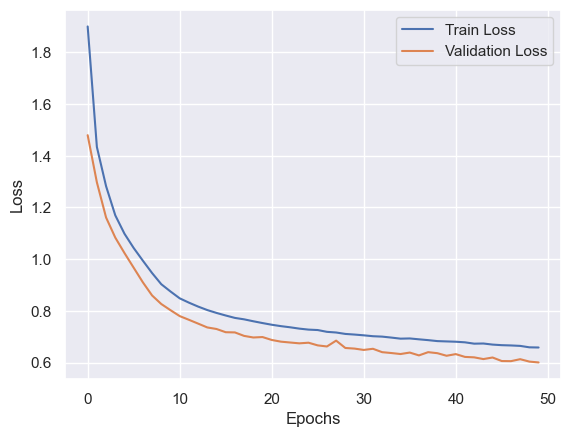

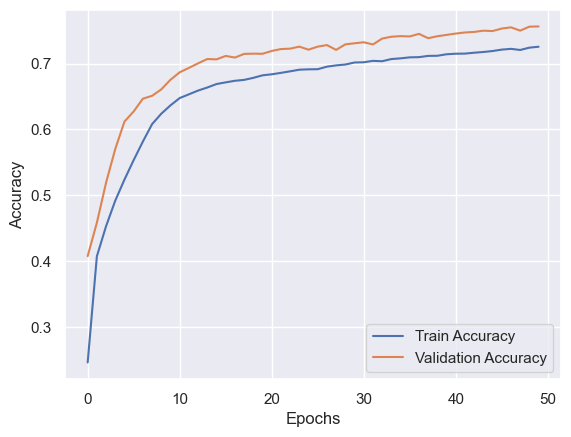

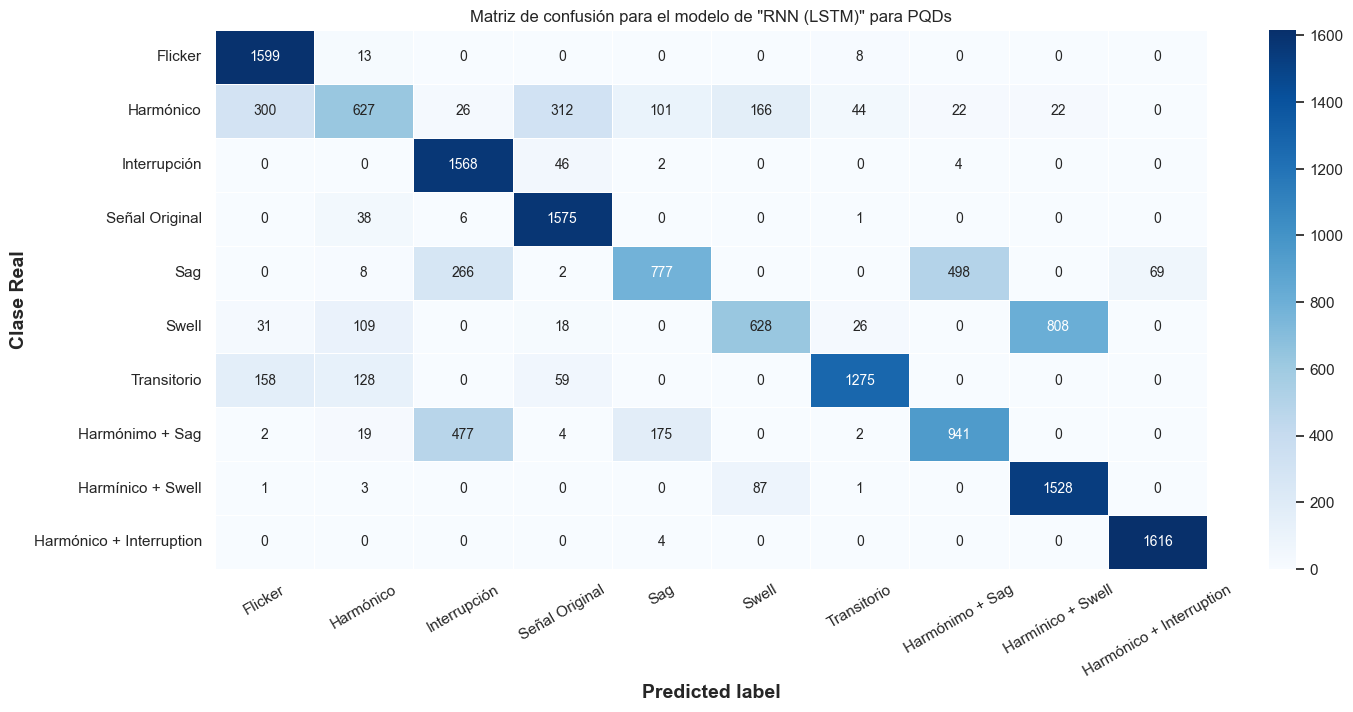

In [8]:
# Gráfico de pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfico de precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Se tiene que haber cargado "confusion_matrix" desde scikit_Learn
matrix = confusion_matrix(y_test, y_pred_classes)

# La mejor dimensión que he encontrado para que se muestre es 16x7, menor se solapan los nombres
plt.figure(figsize=(16,7))
# Simplemente dejar la escala de la fuente en un número que no sea demasiado grande
sns.set(font_scale=1)
# importante fmt = 'd', si no, lo valores se mostrarán porcentualmente. cmap Blues porque me gusta el azul.
sns.heatmap(matrix, annot=True, annot_kws={'size':10},fmt= 'd' ,cmap=plt.cm.Blues, linewidths=0.5)

# Add labels to the plot
class_names = ['Flicker', 'Harmónico', 'Interrupción', 'Señal Original', 'Sag', 'Swell','Transitorio',"Harmónimo + Sag","Harmínico + Swell", "Harmónico + Interruption"]
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=30)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label', weight='bold', fontsize=14)
plt.ylabel('Clase Real', weight='bold', fontsize=14)
plt.title('Matriz de confusión para el modelo de "RNN (LSTM)" para PQDs')
plt.show()